In [ ]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
#Download file dataset from kaggle
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:30<00:00, 31.9MB/s]
100% 2.29G/2.29G [00:30<00:00, 79.6MB/s]


In [ ]:
#Unzip the file
import zipfile
import os

with zipfile.ZipFile('chest-xray-pneumonia.zip','r') as z:
  z.extractall('./')

os.listdir()

['.config',
 'chest_xray',
 'chest-xray-pneumonia.zip',
 'kaggle.json',
 'sample_data']

In [ ]:
train_path = '/content/chest_xray/train'
test_path = '/content/chest_xray/test'
valid_path = '/content/chest_xray/val'

In [ ]:
#See the length of each image directory
print(len(os.listdir(train_path+'/NORMAL'))+len(os.listdir(train_path+'/PNEUMONIA')))
print(len(os.listdir(test_path+'/NORMAL'))+len(os.listdir(test_path+'/PNEUMONIA')))
print(len(os.listdir(valid_path+'/NORMAL'))+len(os.listdir(valid_path+'/PNEUMONIA')))

5216
624
16


In [ ]:
#Define the image generator with augmentation for training images
train_idg = ImageDataGenerator(rescale=1 / 255,
                                  # samplewise_center=True,
                                  # samplewise_std_normalization=True,
                                  horizontal_flip=True,
                                  vertical_flip=False,
                                  height_shift_range=0.05,
                                  width_shift_range=0.1,
                                  rotation_range=5,
                                  shear_range=0.1,
                                  fill_mode='reflect',
                                  zoom_range=0.15)
valid_idg = ImageDataGenerator(rescale=1 / 255)

In [ ]:
#Take the images from directory
train_gen = train_idg.flow_from_directory(train_path,
                                             class_mode='binary',
                                             batch_size=32,
                                             target_size=(224, 224))

valid_gen = valid_idg.flow_from_directory(test_path,
                                             class_mode='binary',
                                             batch_size=32,
                                             target_size=(224, 224))
test_gen = valid_idg.flow_from_directory(valid_path,
                                             class_mode='binary',
                                             batch_size=32,
                                             target_size=(224, 224),shuffle=False)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
#See the labels
train_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

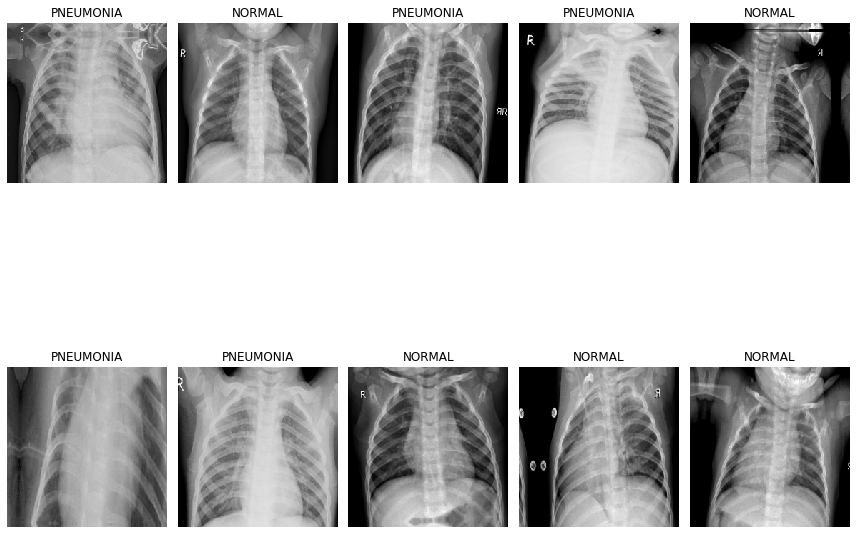

In [ ]:
#Image examples
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train_gen:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [ ]:
#Import DenseNet121 model for transfer learning
pre_trained_model = tf.keras.applications.DenseNet121(input_shape=(224,224,3),                                                     
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
#Lock the model weights
pre_trained_model.trainable = False

In [ ]:
#Take the output of densenet and connect with classification layer
inputs = tf.keras.Input(shape=(224, 224, 3))
x = pre_trained_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(1024, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

model = Model(inputs, outputs) 

#Compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 1,025
Non-trainable params: 7,037,504
_________________________________________________________________


In [ ]:
#Define the callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1)

In [ ]:
#Train the model
history = model.fit(train_gen,  epochs=20, validation_data=valid_gen, callbacks=[reduce_lr])

Epoch 1/20
163/163 [==============================] - 138s 624ms/step - loss: 0.3375 - accuracy: 0.8616 - val_loss: 0.3681 - val_accuracy: 0.8237
Epoch 2/20
163/163 [==============================] - 98s 600ms/step - loss: 0.2055 - accuracy: 0.9268 - val_loss: 0.3517 - val_accuracy: 0.8413
Epoch 3/20
163/163 [==============================] - 98s 601ms/step - loss: 0.1785 - accuracy: 0.9337 - val_loss: 0.3197 - val_accuracy: 0.8606
Epoch 4/20
163/163 [==============================] - 98s 601ms/step - loss: 0.1557 - accuracy: 0.9446 - val_loss: 0.3421 - val_accuracy: 0.8510
Epoch 5/20
163/163 [==============================] - 98s 600ms/step - loss: 0.1456 - accuracy: 0.9479 - val_loss: 0.3166 - val_accuracy: 0.8670
Epoch 6/20
163/163 [==============================] - 98s 599ms/step - loss: 0.1445 - accuracy: 0.9480 - val_loss: 0.3565 - val_accuracy: 0.8413
Epoch 7/20
163/163 [==============================] - 97s 598ms/step - loss: 0.1309 - accuracy: 0.9548 - val_loss: 0.3340 - val_a

Text(0, 0.5, 'Accuracy and Loss')

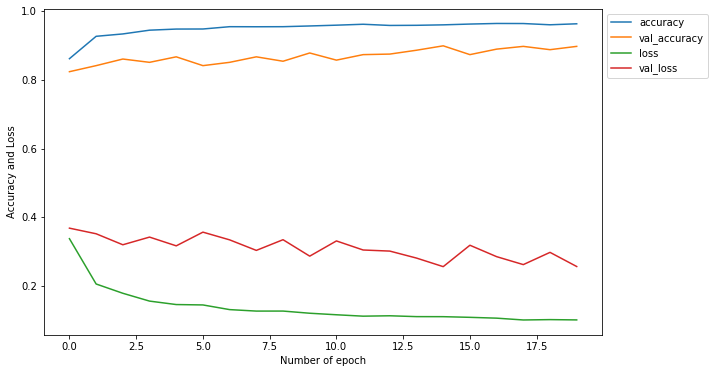

In [ ]:
#Plot the accuracy and loss history
fig, axes = plt.subplots(figsize=(10,6))
axes.plot(history.history['accuracy'],label='accuracy')
axes.plot(history.history['val_accuracy'],label='val_accuracy')
axes.plot(history.history['loss'],label='loss')
axes.plot(history.history['val_loss'],label='val_loss')
axes.legend(loc='best', bbox_to_anchor=(1, 1))
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy and Loss')

In [ ]:
#Use the model to predict the test images
pred = model.predict(test_gen, verbose=1)

1/1 [==============================] - 2s 2s/step


In [ ]:
prediction = pred > 0.5

In [ ]:
#Import the metrics for classification
from sklearn.metrics import classification_report,confusion_matrix
data = confusion_matrix(test_gen.classes,prediction,)

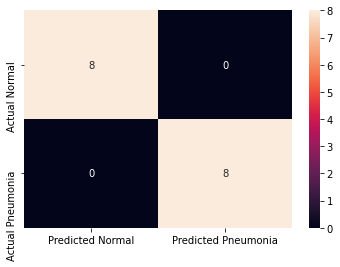

In [ ]:
#Plot the confusion matrix with heatmap
cm = pd.DataFrame(data=confusion_matrix(test_gen.classes, prediction, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm, annot=True)

In [ ]:
#See the classification report
print(classification_report(test_gen.classes,prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



In [ ]:
#Save the model
model.save('pneumonia_classifier.h5')